# Семинар 1

Фиксированная и плавающая точка, векторные нормы и понятие устойчивости алгоритмов.

## 🧐 Почему `0.1 + 0.2 != 0.3`?

Числа с плавающей запятой в Python хранятся в формате **IEEE 754**, который использует **бинарное представление** чисел. Однако не все десятичные дроби можно точно представить в двоичной системе. Например:

- Десятичное `0.1` в двоичном формате представляется бесконечной дробью:  
  ```
  0.0001100110011001100110011001100110011... (повторяется бесконечно)
  ```
- То же самое касается `0.2`:  
  ```
  0.001100110011001100110011001100110011... (тоже бесконечная дробь)
  ```

Так как компьютер работает с ограниченной точностью, он **усекает** эти дроби, оставляя только конечное число битов. Это приводит к небольшим ошибкам округления.

### 🧮 Доказательство в Python

Если вывести точное двоичное представление `0.1`, `0.2` и `0.3`, можно увидеть разницу:


In [3]:
from decimal import Decimal

print(Decimal(0.1))  # 0.1000000000000000055511151231257827021181583404541015625
print(Decimal(0.2))  # 0.200000000000000011102230246251565404236316680908203125
print(Decimal(0.3))  # 0.299999999999999988897769753748434595763683319091796875

0.1000000000000000055511151231257827021181583404541015625
0.200000000000000011102230246251565404236316680908203125
0.299999999999999988897769753748434595763683319091796875


Теперь сложим `0.1 + 0.2`:

In [4]:
print(Decimal(0.1) + Decimal(0.2))  

0.3000000000000000166533453694


А `0.3` на самом деле:

In [5]:
print(Decimal(0.3))  

0.299999999999999988897769753748434595763683319091796875


Они **не равны** из-за разницы в последних разрядах!

### 🤔 Как правильно сравнивать?

Поскольку числа с плавающей запятой содержат небольшие ошибки округления, их **нельзя сравнивать напрямую** с `==`. Вместо этого используют **погрешность** (`epsilon`):

In [6]:
import math

a = 0.1 + 0.2
b = 0.3

print(math.isclose(a, b, rel_tol=1e-9)) 

True


Функция `math.isclose()` проверяет, находятся ли два числа **достаточно близко** друг к другу с учетом заданной относительной ошибки.

## Числа с фиксированной точкой
Число с фиксированной точкой состоит из 1-битного знака, $m$-битного целого и $n$-битного дробного числа:
$$
\text{decimal} = 
(-1)^{\text{sign}} \times 
\Big(
\sum_{i=0}^{m-1} \text{integer}[i] \cdot base^{m-1-i} + 
\sum_{i=0}^{n-1} \text{fractional}[i] \cdot base^{-i-1}
\Big)
$$

- диапазон $[-2^m + 2^{-n}, 2^m - 2^{-n}]$
- разрешение $2^{-n}$
- общее количество бит $m + n + 1$

In [1]:
def binary_fixed_point_to_decimal(x, m=8, n=8):
    """
    x - binary string of size 1 + m + n
    m - size of an integer part
    n - sze of a fractional part
    """
    sign_part, integer_part, fractional_part = x[0], x[1:m+1], x[m+1:m+n+1]
    sign_value = (-1) ** int(sign_part)
    integer_value = sum([
        int(v) * 2 ** i
        for i, v in enumerate(integer_part[::-1])
    ])
    fractional_value = sum([
        int(v) * 2 ** -(i + 1)
        for i, v in enumerate(fractional_part)
    ])
    return sign_value * (integer_value + fractional_value)

m, n = 8, 8
x = '00000010100100000'
print(binary_fixed_point_to_decimal(x, m, n) == 5.125)

True


In [2]:
x = '11111111111111111' # Insert a string corresponding to a minimal possible value
print(binary_fixed_point_to_decimal(x, m, n) == -(2 ** m - 2 ** (-n)))

True


In [3]:
x = '01111111111111111' # Insert a string corresponding to a maximal possible value
print(binary_fixed_point_to_decimal(x, m, n) == 2 ** m - 2 ** (-n))

True


In [4]:
x = '00000000000000001' # Insert a string corresponding to an absolute minimal but nonzero possible value
print(binary_fixed_point_to_decimal(x, m, n) == 2 ** (-n))

True


Основной недостаток чисел с фиксированной точкой — ограниченный диапазон и разрешение. Например, для 8-битного формата:
- диапазон $[-128, 127]$
- разрешение $2^{-7} = 0.0078125$

Это означает, что для представления очень больших или очень маленьких чисел потребуется больше бит.

Для 32-битного формата:
- диапазон $[-2^{31}, 2^{31} - 1]$
- разрешение $2^{-23} \approx 1.192 \times 10^{-7}$

Это означает, что для представления очень больших или очень маленьких чисел потребуется больше бит.

## Числа с плавающей точкой
Числа с плавающей точкой состоят из 1-битного знака, $m$-битного экспоненты и $n$-битного мантиссы:

$$
\text{decimal} = 
(-1)^{\text{sign}} \times 
base^{\Big(\sum_{i=0}^{m-1} \text{exponent}[i] \cdot base^{m-1-i} - (2^{m-1} - 1)\Big)}
\times
\Big(1 + \sum_{i=0}^{n-1} \text{mantissa}[i] \cdot base^{-i-1}\Big)
$$

- значения экспоненты, равные 0 и 1, зарезервированы для специальных чисел: NaN, бесконечность и т.д.
- общее количество бит $m + n + 1$

Half (float16) vs Single (float32) vs and Double (float32) Точность

- float16 - 16 bit total: 1 for a sign, $m = 5$ for exponent and $n = 10$ for mantissa
- float32 - 32 bits total: 1 for a sign, $m = 8$ for exponent and $n = 23$ for mantissa
- float64 - 64 bits total: 1 for a sign, $m = 11$ for exponent and $n = 52$ for mantissa

In [8]:
def binary_floating_point_to_decimal(x, m=8, n=23):
    """
    x - binary string of size 1 + m + n
    m - size of an exponent part
    n - sze of a mantissa part
    """
    sign_part, exponent_part, mantissa_part = x[0], x[1:m+1], x[m+1:n+m+1]
    sign_value = (-1) ** int(sign_part)

    mantissa_value = 1
    for i, v in enumerate(mantissa_part):
        mantissa_value += int(v) * (2 ** -(i + 1))

    exponent_value = 0
    for i, v in enumerate(exponent_part):
        exponent_value += int(v) * 2 ** i
    exponent_value -= (2 ** (m - 1) - 1)
        
    return sign_value * (2 ** exponent_value) * mantissa_value

m, n = 8, 23
x = '01000000101001000000000000000000'
print(binary_floating_point_to_decimal(x, m, n) == 5.125)

True


## Ошибки округления

Из-за того, что представления с плавающей точкой являются лишь приближениями к действительным числам, могут возникать ошибки округления.

Например, рассмотрим простой алгоритм суммирования, где $x_i$ — числа с плавающей точкой:

$$
f(x) = x_1 + x_2 + ... + x_n
$$

Реализуйте простой алгоритм из лекции (добавляя по одному):

[!] Установите $n$ равным 1000 и все $x_i$ равными 0.1.

In [9]:
total = 0.0
for _ in range(1000):
    total += 0.1

print("Expected result: 100.0")
print(f"Actual result:", total)

Expected result: 100.0
Actual result: 99.9999999999986


Реализуйте алгоритм Кахана из лекции и проверьте возникающую ошибку.

[!] Установите $n$ равным 1000 и все $x_i$ равными 0.1.

In [10]:
s = 0
c = 0
for i in range(1000):
    y = 0.1 - c
    t = s + y
    c = (t - s) - y
    s = t

print("Expected result: 100.0")
print(f"Actual result:", s)

Expected result: 100.0
Actual result: 100.0


Объяснение: значение 0.1 не может быть точно представлено в двоичной системе, поэтому оно становится приближением. Когда это приближение добавляется по одному, малые ошибки округления накапливаются, что приводит к конечному результату, немного меньшему, чем 100.0.

## Векторы и векторные нормы
В NLA мы обычно работаем не с числами, а с векторами, которые являются просто массивами чисел размера $n$.

In [11]:
import numpy as np

x = np.array([1, 2, 3, 4, 5])

print(f'Size of the x vector is {len(x)}')
print(f'Type of the vector elements is {type(x[0])}')

Size of the x vector is 5
Type of the vector elements is <class 'numpy.int64'>


Как видите, этот вектор содержит только целые значения. Теперь преобразуйте их в тип float32.

In [12]:
x = x.astype(np.float32)
print(f'Type of the vector elements is {type(x[0])}')

Type of the vector elements is <class 'numpy.float32'>


Для измерения малости вектора используется его **норма** $\|x\|$.

Самый важный класс норм — $p$-нормы:
$$
\|x\|_p = \Big(\sum_{i=1}^n |x_i|^p\Big)^{1/p}
$$
Примеры $p$-норм:
- Манхэттенское расстояние или $L_1$ норма - когда $p=1$
- Евклидова норма или $L_2$ норма - когда $p=2$
- Бесконечная норма, или норма Чебышева - когда $p=+\infty$: $ \|x\|_{\infty} = \max_i | x_i|$
  

Посчитайте нормы для вектора $x$:

Подсказка: используйте `np.linalg.norm`

In [13]:
print('L1 norm:', np.linalg.norm(x, 1))
print('L2 norm:', np.linalg.norm(x, 2))
print('Chebyshev norm:', np.linalg.norm(x, np.inf))

L1 norm: 15.0
L2 norm: 7.4161983
Chebyshev norm: 5.0


Единичный диск для $p$-нормы — это множество точек таких, что $\|x\|_p = 1$.

Визуализируйте единичный диск для следующих $p$-норм: $p \in (0.25, 0.75, 1.0, 2.0, 5.0, \infty)$

Подсказка: $y = \pm (1 - |x|^p)^{1/p}$

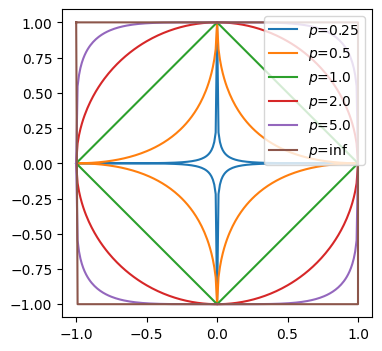

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def unit_disk(p):
    x = np.linspace(-1, 1, 201)
    y = (1 - np.abs(x) ** p) ** (1 / p)
    x = np.hstack([x, x[1:][::-1], x[0]])
    y = np.hstack([y, -y[1:][::-1], y[0]])
    return x, y

plt.figure(figsize=(4, 4))
plt.axis('equal')
for p in (0.25, 0.5, 1.0, 2.0, 5.0, np.inf):
    x, y = unit_disk(p)
    plt.plot(x, y, label=f'$p$={p}')
plt.legend(loc=1)
plt.show()

![](p_balls.svg)

## Устойчивость
Предположим, у нас есть вектор $x$, функция $f(x)$, и алгоритм $\text{alg}(x)$ для приближения функции. Тогда алгоритм называется **устойчивым в прямом направлении**, если для некоторого малого $\varepsilon$

$$
\|\text{alg}(x) - f(x)\|  \leq \varepsilon
$$

[Задание] Проверьте суммирующие алгоритмы, упомянутые ранее (простой и Кахана) на устойчивость в прямом направлении. 

Пусть $x_i = 0.1$ и $n = 100$.
$$
f(x) = \sum_{i=1}^{100} x_i, \;\;
x_i = 0.1
$$
Запишите ошибку, возникающую в каждом шаге суммирования: 
$$
\text{error}[i] = |0.1 \cdot i - \text{alg}(x)|
$$

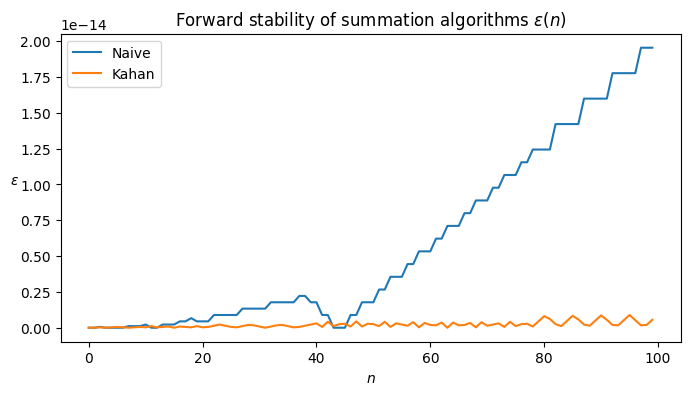

In [15]:
from matplotlib import pyplot as plt
N = 100

# Naive
total = 0.0
error_naive = []
for i in range(N):
    total += 0.1
    refer = (i + 1) / 10
    error_naive.append(np.abs(refer - total))

# Kahan
s = 0
c = 0
error_kahan = []
for i in range(N):
    y = 0.1 - c
    t = s + y
    c = (t - s) - y
    s = t
    error_kahan.append(np.abs(c))

plt.figure(figsize=(8, 4))
plt.title(r'Forward stability of summation algorithms $\varepsilon(n)$')
plt.plot(error_naive, label='Naive')
plt.plot(error_kahan, label='Kahan')
plt.ylabel(r'$\varepsilon$', rotation=0)
plt.xlabel(r'$n$')
plt.legend()
plt.show()

What do you see?

## Простая, но очень важная идея умножения матриц
Предположим, у вас есть следующее выражение:
$$
b = A_1 A_2 A_3 x,
$$
где $A_1, A_2, A_3 \in \mathbb{R}^{3 \times 3}$ - случайные квадратные плотные матрицы, а $x \in \mathbb{R}^n$ - вектор. Вам нужно вычислить $b$.
Какой способ лучше всего использовать?

$A_1 A_2 A_3 x$ (слева направо)
$\left(A_1 \left(A_2 \left(A_3 x\right)\right)\right)$ (справа налево)
Не имеет значения
Результаты первых двух вариантов не будут одинаковыми.

In [17]:
import numpy as np

# Function to create a random square matrix of size n
def create_random_matrix(n):
    return np.random.rand(n, n)

# Define the size of the matrices
n = 200

# Create a list of 3 random matrices
matrices = [create_random_matrix(n) for _ in range(3)]
y = np.random.rand(n, 1)  # y is a vector

# Function to compute the expression in a given order
def compute_expression(matrices, y, reverse=False):
    result = y
    if reverse:
        # Start with y and multiply with each matrix from right to left
        for matrix in reversed(matrices):
            result = matrix @ result
    else:
        # Start with the first matrix and multiply each next matrix from left to right
        result = matrices[0]
        for matrix in matrices[1:]:
            result = result @ matrix
        # Finally multiply with y
        result = result @ y
    return result

# Time the expression from left to right
print("💎 From left to right")
%timeit compute_expression(matrices, y)

# Time the expression from right to left
print("💎 From right to left")
%timeit compute_expression(matrices, y, reverse=True)

💎 From left to right
706 µs ± 62 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
💎 From right to left
24.9 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
